In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as mpl
import obspy as op
import glob
import os
import shutil
import fnmatch
import shutil
import matplotlib.gridspec as gridspec
from scipy import fftpack
from scipy import signal
from obspy.taup import TauPyModel
from itertools import compress
import time
from IPython import display
from mpl_toolkits.basemap import Basemap

<h2 align="center">Estação NBLA</h2>

<p>Network: NB</p>
<p>Station: NBLA</p>
<p>Date Begin: 2013-02-19 21:10:15.0</p>
<p>Description: Lagarto- SE, Brazil</p>
<p>Country: Brasil</p>
<p>Latitude: -10.99255</p>
<p>Longitude: -37.789</p>

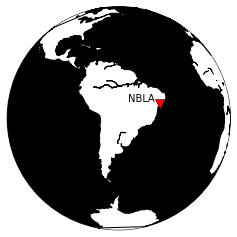

In [3]:
m = Basemap(projection='ortho',lon_0=-60,lat_0=-20)
m.drawmapboundary(fill_color='k')
m.fillcontinents(color='w',lake_color='k')
m.drawcoastlines()

m.plot(-37.789,-10.99255,marker='v',color='r',latlon=True,markersize=10,label='NBLA')
mpl.annotate('NBLA', xy=(128,136),xycoords='figure points')

<h2 align="center">Curvas de Dispersão</h2>

<h5 align="justify">Pasta de trabalho</h5>

In [4]:
os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/urayl.NBLA/')

<h5 align="justify">Convertendo o arquivo de sac para txt para poder plotar</h5>

In [5]:
os.system('sac2xy 2 urayl.NBLA > NBLA_urayl.txt')

0

<h5 align="justify">Importando a curva de dispersão para a estação NBLA</h5>

In [6]:
CD = np.genfromtxt('NBLA_urayl.txt')

In [7]:
periods = CD[:,0]
disp_curves = CD[:,1]

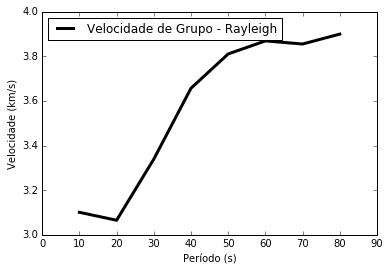

In [8]:
ax1 = mpl.subplot()
ax1.plot(periods,disp_curves,'k',lw=3,label='Velocidade de Grupo - Rayleigh')
ax1.set_xlabel('Período (s)')
ax1.set_ylabel('Velocidade (km/s)')   
ax1.set_xlim(0,90)
ax1.set_ylim(3,4)
ax1.legend(loc=0)

<h2 align="center">Funções do Receptor</h2>

<h5 align="justify">Pasta de trabalho</h5>

In [9]:
os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/')

<h5 align="justify">Importando as Funções do Receptor do Projeto I</h5>

In [45]:
RF_listR = []
RF_listT = []
for root, dirs, files in os.walk('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/'):
    for invfile in files:
        if invfile.startswith('Rdecon.'):
            RF_listR.append(os.path.join(root, invfile))        
        if invfile.startswith('Tdecon.'):
            RF_listT.append(os.path.join(root, invfile))
RF_listRS = sorted(RF_listR)
RF_listTS = sorted(RF_listT)

In [52]:
RF_Rdecon = [op.read(i) for i in RF_listRS[:17]]
RF_Tdecon = [op.read(i) for i in RF_listTS]

In [53]:
print('Número de Funções do Receptor = '+str(len(RF_Rdecon)))

Número de Funções do Receptor = 17


<h5 align="justify">Mudando a taxa amostral das Função do Receptor</h5>

In [54]:
for i in RF_Rdecon:
    i.interpolate(sampling_rate=10)

In [57]:
k =17

In [58]:
RF_Rdecon1 = [RF_Rdecon[i:i+k] for i in range(0, len(RF_Rdecon), k)]
RF_Tdecon1 = [RF_Tdecon[i:i+k] for i in range(0, len(RF_Tdecon), k)]

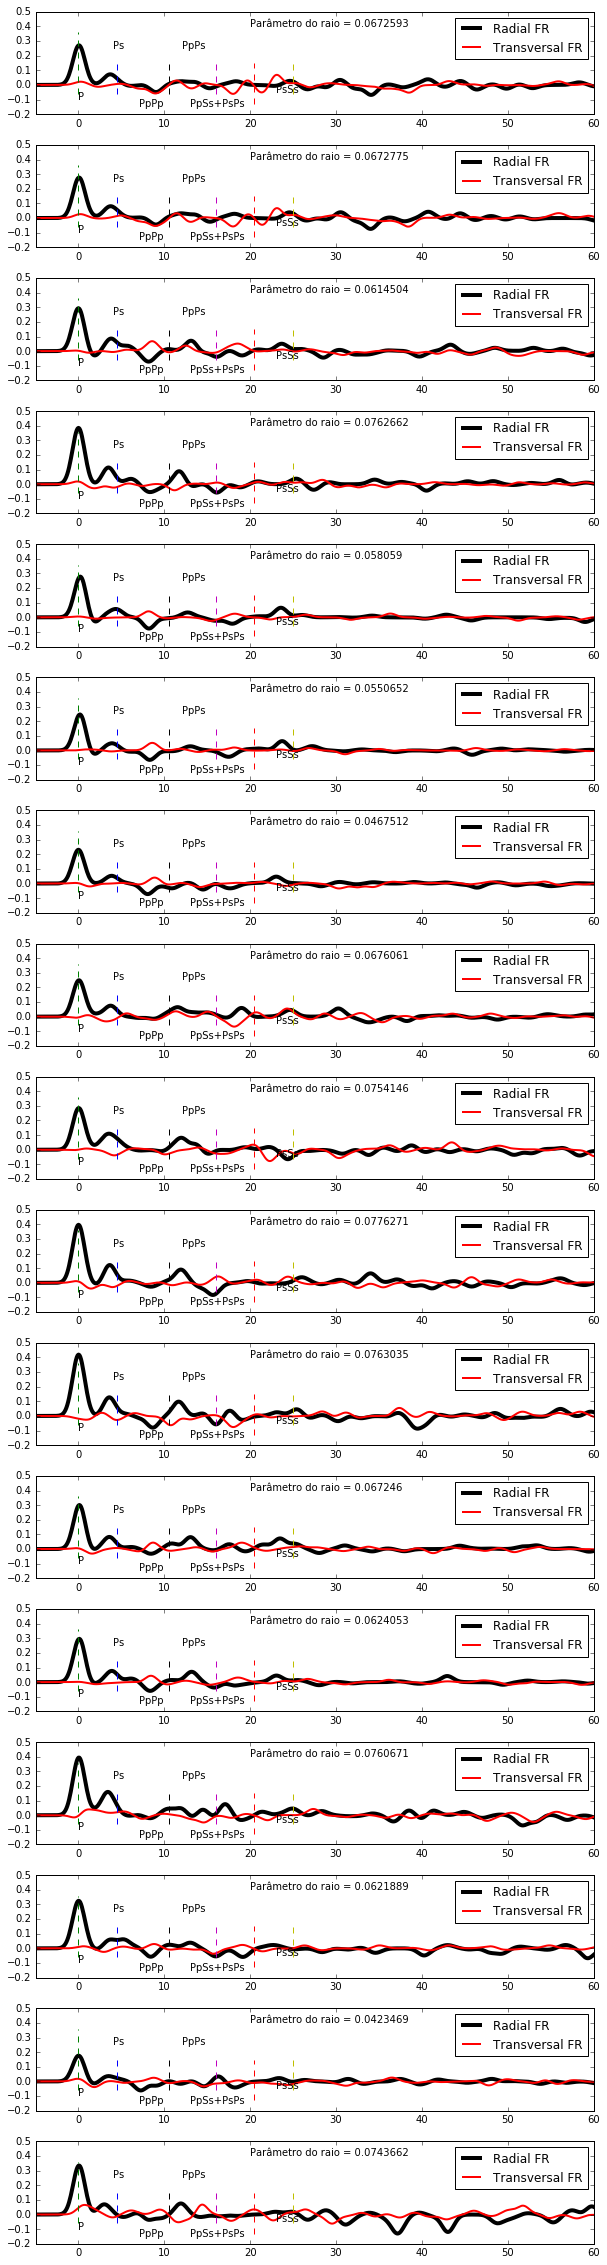

In [59]:
fig = mpl.figure(figsize = (10,40))
gs1 = gridspec.GridSpec(len(RF_Rdecon),len(RF_Rdecon1))
gs1.update(wspace=0.3, hspace=0.3)
for i,j in enumerate(RF_Rdecon1):
    for h in range(len(RF_Rdecon1[0])):
        ax1 = mpl.subplot(gs1[h,i])
        ax1.plot(j[h][0].times()-5,j[h][0].data,'k',lw=4,label='Radial FR')
        ax1.plot(RF_Tdecon1[i][h][0].times()-5,RF_Tdecon1[i][h][0],'r',lw=2,label='Transversal FR')
        ax1.text(20, 0.4, 'Parâmetro do raio = '+str(j[h][0].stats.sac.user8))
        ax1.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
        ax1.text(0, -0.1, 'P')
        ax1.axvline(x=4.5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
        ax1.text(4, 0.25, 'Ps')
        ax1.axvline(x=10.5, ymin=0.2, ymax=0.5, ls='dashed',c='k')
        ax1.text(7, -0.15, 'PpPp')    
        ax1.axvline(x=16, ymin=0.2, ymax=0.5, ls='dashed',c='m')
        ax1.text(12, 0.25, 'PpPs')
        ax1.axvline(x=20.5, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
        ax1.text(13, -0.15, 'PpSs+PsPs')
        ax1.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
        ax1.text(23, -0.05, 'PsSs')
        ax1.set_xlim(-5,60)
        ax1.set_ylim(-0.2,0.5)
        ax1.legend(loc=0)

<h5 align="justify">Empilhamento das Funções do Receptor</h5>

Empilhar	  as	  funções	   de	   receptor,	   tendo	   em	   conta	   que	   a	   variação	   no	   parâmetro	   do	   raio	   das	  funções	  empilhadas	  deve	  ser	  <	  0.01	  s/km.	 


Organizando as Funções do Receptor de acordo com o parâmetro do raio e empilhando as Funções do Receptor.

In [60]:
list_org = np.argsort([j[0].stats.sac.user8 for j in RF_Rdecon])

In [61]:
RF_Rdecon_stack1 = []
PR_Rdecon_stack1 = []
RF_Rdecon_stack2 = []
PR_Rdecon_stack2 = []

for i in list_org:
    if RF_Rdecon[i][0].stats.sac.user8 <= 0.06:
        RF_Rdecon_stack1.append(RF_listRS[i])
        PR_Rdecon_stack1.append(RF_Rdecon[i][0].stats.sac.user8)
    else:
        RF_Rdecon_stack2.append(RF_listRS[i])
        PR_Rdecon_stack2.append(RF_Rdecon[i][0].stats.sac.user8)

<h5 align="justify">Empilhando as Funções do Receptor em dois grupo: </h5>

In [62]:
os.mkdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_1')
os.mkdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_2')

<h5>1 - Parâmetro do raio 0.04 a 0.05</h5>

In [63]:
os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_1')

In [64]:
RF_Rdecon_stack1_name = [i.split('NBLA/')[1] for i in RF_Rdecon_stack1]
np.savetxt('list',RF_Rdecon_stack1_name,fmt='%s')
np.savetxt('play_stack',['list','n','stack_grupo_1.sac'],fmt='%s')

In [65]:
for k,l in enumerate(RF_Rdecon_stack1):
    shutil.copy2(l,'/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_1/'+RF_Rdecon_stack1_name[k])

In [66]:
os.system('stacksac n ON < play_stack')

0

<h5>2 - Parâmetro do raio 0.06 a 0.07</h5>

In [67]:
os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_2')

In [68]:
RF_Rdecon_stack2_name = [i.split('NBLA/')[1] for i in RF_Rdecon_stack2]
np.savetxt('list',RF_Rdecon_stack2_name,fmt='%s')
np.savetxt('play_stack',['list','n','stack_grupo_2.sac'],fmt='%s')

In [69]:
for k,l in enumerate(RF_Rdecon_stack2):
    shutil.copy2(l,'/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_2/'+RF_Rdecon_stack2_name[k])

In [70]:
os.system('stacksac n ON < play_stack')

0

<h5>Plotando as Funções do Receptor Empilhadas</h5>

In [81]:
os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA')

In [82]:
RF_stack1 = op.read("grupo_1/stack_grupo_1.sac")
RF_stack2 = op.read("grupo_2/stack_grupo_2.sac")

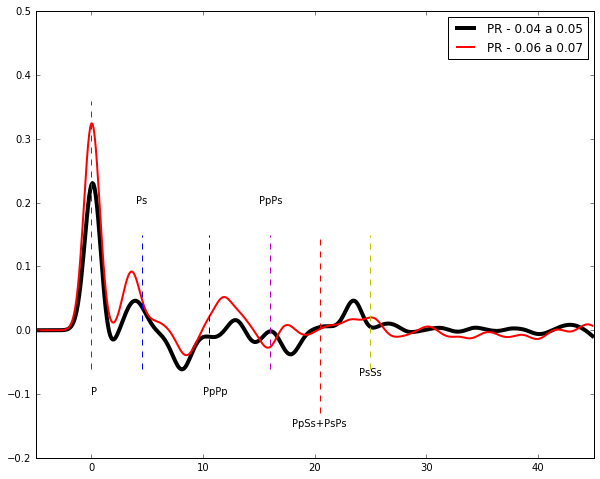

In [93]:
fig = mpl.figure(figsize = (10,8))
ax1 = mpl.subplot()
ax1.plot(RF_stack1[0].times()-5,RF_stack1[0].data,'k',lw=4,label='PR - 0.04 a 0.05')
ax1.plot(RF_stack2[0].times()-5,RF_stack2[0].data,'r',lw=2,label='PR - 0.06 a 0.07')
ax1.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
ax1.text(0, -0.1, 'P')
ax1.axvline(x=4.5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
ax1.text(4, 0.2, 'Ps')
ax1.axvline(x=10.5, ymin=0.2, ymax=0.5, ls='dashed',c='k')
ax1.text(10, -0.1, 'PpPp')    
ax1.axvline(x=16, ymin=0.2, ymax=0.5, ls='dashed',c='m')
ax1.text(15, 0.2, 'PpPs')
ax1.axvline(x=20.5, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
ax1.text(18, -0.15, 'PpSs+PsPs')
ax1.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
ax1.text(24, -0.07, 'PsSs')
ax1.set_xlim(-5,45)
ax1.set_ylim(-0.2,0.5)
ax1.legend(loc=0)

<h2 align="center">Inversão Conjunta das Curvas de Dispersão e das Funções do Receptor</h2>

In [173]:
os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/')

<h5>Criando o modelo de velocidade inicial</h5>

In [174]:
model_true = ['5', '1', '1','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 2','7 0','y','model.ini','modelo inicial']
np.savetxt('model_ini.txt',model_true,fmt='%s')
os.system('icmod < model_ini.txt')

0

<h5>Criando as pastas e os arquivos para fazer a inversão jointsmth para cara grupo de Funções do Receptor Empilhadas</h5>

In [243]:
stack_list = ['grupo_1','grupo_2']
para_infl = [0.3,0.4,0.5,0.6,0.7]
PR_grupo = [0.05,0.07]

In [244]:
for i,j in enumerate(stack_list):
    os.mkdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'+j)

In [245]:
for i,j in enumerate(stack_list):
    for k,l in enumerate(para_infl):
        os.mkdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'+j+'/'+str(l))
        shutil.copy2('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/model.ini','/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'+j+'/'+str(l)+'/model.ini')
        shutil.copy2('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/urayl.NBLA/urayl.NBLA','/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'+j+'/'+str(l)+'/urayl.NBLA') 

In [246]:
for k,l in enumerate(para_infl):
    shutil.copy2('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_1/stack_grupo_1.sac','/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/grupo_1/'+str(l)+'/model.true.eqr')
    shutil.copy2('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/rftn.NBLA/grupo_2/stack_grupo_2.sac','/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/grupo_2/'+str(l)+'/model.true.eqr')    

In [247]:
for i,j in enumerate(stack_list):
    for k,l in enumerate(para_infl):
        os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'+j+'/'+str(l))
        obsr = ['1','"model.true.eqr"',str(PR_grupo[i]),'2.5','5.']
        obsd = ['1','"urayl.NBLA"','2.0 5.0 0.05 0.0001 10']
        obsj = ['6',str(l),'5','-1.0','-1.0', '55', '0.0']
        np.savetxt('obs.r',obsr,fmt='%s')
        np.savetxt('obs.d',obsd,fmt='%s')
        np.savetxt('obs.j',obsj,fmt='%s')
        os.system('tjo2jjc < model.ini > model.0')
        os.system('jointsmth')
        os.system('sac2xy 2 model.6.vs > model_6_vs_'+j+str(l)+'.txt')

In [248]:
for i,j in enumerate(stack_list):
    for k,l in enumerate(para_infl):
        os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'+j+'/'+str(l))
        os.system('sac2xy 2 model.6.vs > model_6_vs_'+j+str(l)+'.txt')

<h4>Plotando os modelos gerados pela inversão jointsmth</h4>

In [249]:
model_vs_list = []
for root, dirs, files in os.walk('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'):
    for invfile in files:
        if invfile.startswith('model_6_vs_grupo_'):
            model_vs_list.append(os.path.join(root, invfile))
model_vs_listS = sorted(model_vs_list)

In [250]:
model_joint = [np.genfromtxt(j) for j in model_vs_listS]
model_joint_label = [i.split('/')[9] for i in model_vs_listS]

In [251]:
vs = []
prof = []
for i,j in enumerate(model_joint):
    vs.append(j[:,0])
    prof.append((-1)*(j[:,1]))

In [252]:
prof1 = [prof[i:i+5] for i in range(0, len(prof), 5)]
vs1 = [vs[i:i+5] for i in range(0, len(vs), 5)]
model_joint_label1 = [model_joint_label[i:i+5] for i in range(0, len(model_joint_label), 5)]

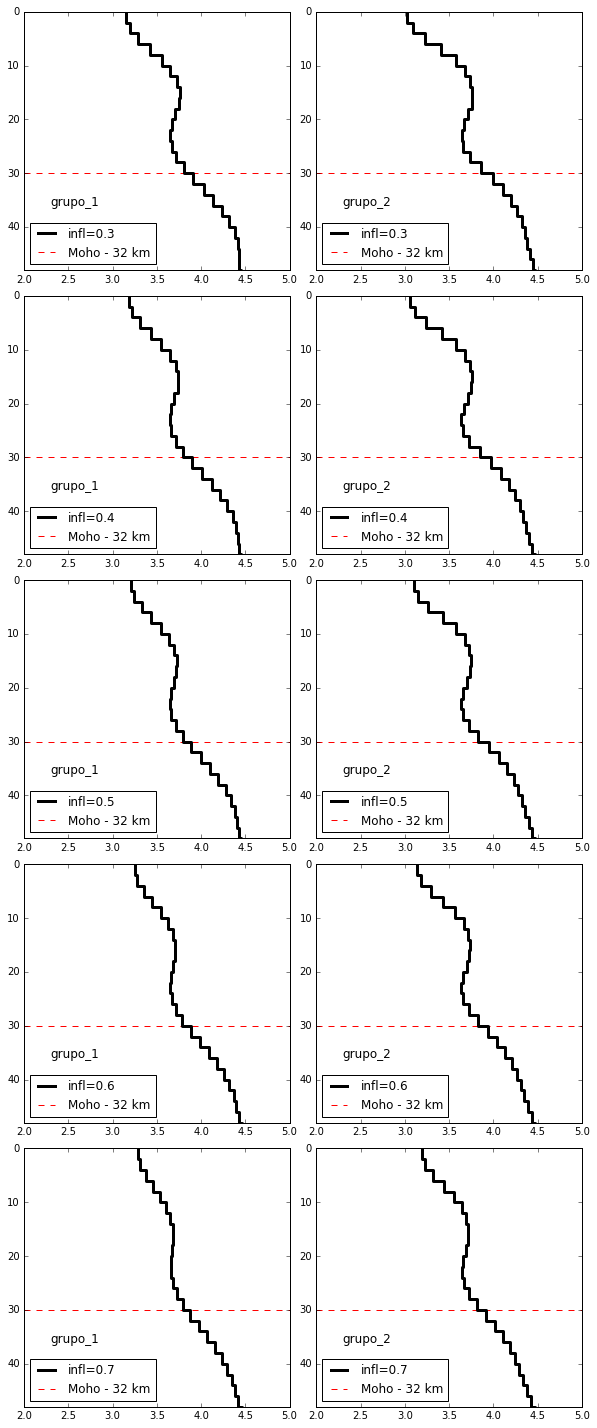

In [253]:
fig = mpl.figure(figsize = (10,25))
gs1 = gridspec.GridSpec(len(vs1[0]),len(vs1))
gs1.update(wspace=0.1, hspace=0.1)
for i,j in enumerate(vs1):
        for k,l in enumerate(vs1[0]):
            ax1 = mpl.subplot(gs1[k,i])
            ax1.step(vs1[i][k],prof1[i][k],'k',lw=3,where='post',label='infl='+model_joint_label1[i][k])
            ax1.hlines(30,2,5,'r',linestyles='dashed',label='Moho - 32 km')
            ax1.text(2.3,36,stack_list[i],fontsize=12)
            ax1.set_xlim([2,5])
            ax1.set_ylim([48,0])
            ax1.legend(loc=3)

<h4>Plotando as Funções do Receptor geradas pela inversão jointsmth</h4>

In [254]:
RF_vs_list = []
for root, dirs, files in os.walk('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'):
    for invfile in files:
        if invfile.startswith('syn.6.rftn'):
            RF_vs_list.append(os.path.join(root, invfile))
RF_vs_listS = sorted(RF_vs_list)

In [255]:
RF_joint = [op.read(j) for j in RF_vs_listS]

In [256]:
RF_joint_data = []
RF_joint_time = []
for i,j in enumerate(RF_joint):
    a = j[0]
    RF_joint_data.append(a.data)
    RF_joint_time.append(a.times())

In [257]:
RF_joint_data1 = [RF_joint_data[i:i+5] for i in range(0, len(RF_joint_data), 5)]
RF_joint_time1 = [RF_joint_time[i:i+5] for i in range(0, len(RF_joint_time), 5)]

In [258]:
RF_grupos = [RF_stack1[0],RF_stack2[0]]
RF_grupos_label = ['PR - 0.04 a 0.05','PR - 0.06 a 0.07']

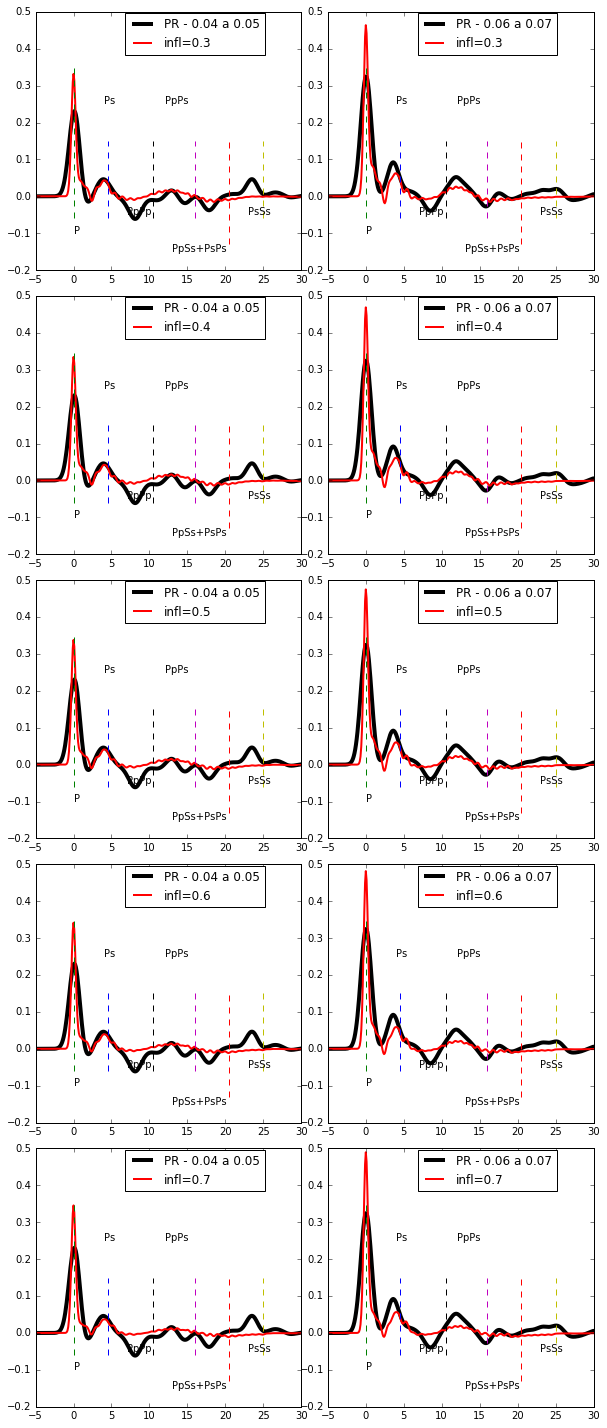

In [259]:
fig = mpl.figure(figsize = (10,25))
gs1 = gridspec.GridSpec(len(RF_joint_data1[0]),len(RF_joint_data1))
gs1.update(wspace=0.1, hspace=0.1)
for i,j in enumerate(RF_joint_data1):
        for k,l in enumerate(RF_joint_data1[0]):
            ax1 = mpl.subplot(gs1[k,i])
            ax1.plot(RF_grupos[i].times()-5,RF_grupos[i].data,'k',lw=4,label=RF_grupos_label[i])
            ax1.plot(RF_joint_time1[i][k]-5,RF_joint_data1[i][k],'r',lw=2,label='infl='+model_joint_label1[i][k])
            ax1.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
            ax1.text(0, -0.1, 'P')
            ax1.axvline(x=4.5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
            ax1.text(4, 0.25, 'Ps')
            ax1.axvline(x=10.5, ymin=0.2, ymax=0.5, ls='dashed',c='k')
            ax1.text(7, -0.05, 'PpPp')    
            ax1.axvline(x=16, ymin=0.2, ymax=0.5, ls='dashed',c='m')
            ax1.text(12, 0.25, 'PpPs')
            ax1.axvline(x=20.5, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
            ax1.text(13, -0.15, 'PpSs+PsPs')
            ax1.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
            ax1.text(23, -0.05, 'PsSs')
            ax1.set_xlim(-5,30)
            ax1.set_ylim(-0.2,0.5)
            ax1.legend(bbox_to_anchor=(0.6, 1.0), loc=9, borderaxespad=0.1)

<h4>Plotando as Curvas de Dispersão geradas pela inversão jointsmth</h4>

In [260]:
for i,j in enumerate(stack_list):
    for k,l in enumerate(para_infl):
        os.chdir('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'+j+'/'+str(l))
        os.system('sac2xy 2 syn.6ur.disp > syn_6ur.txt')

In [261]:
CD_vs_list = []
for root, dirs, files in os.walk('/home/diogo/Dropbox/UFRN/Aplicações_Sismológicas/exerc_aplicacoes_dIOGO/projeto_II/'):
    for invfile in files:
        if invfile.startswith('syn_6ur.'):
            CD_vs_list.append(os.path.join(root, invfile))
CD_vs_listS = sorted(CD_vs_list)

In [262]:
CD_r_cur = [np.genfromtxt(j)[:,1] for j in CD_vs_listS]
periodsr = [np.genfromtxt(j)[:,0] for j in CD_vs_listS]

In [263]:
CD_r_cur1 = [CD_r_cur[i:i+5] for i in range(0, len(CD_r_cur), 5)]
periodsr1 = [periodsr[i:i+5] for i in range(0, len(periodsr), 5)]

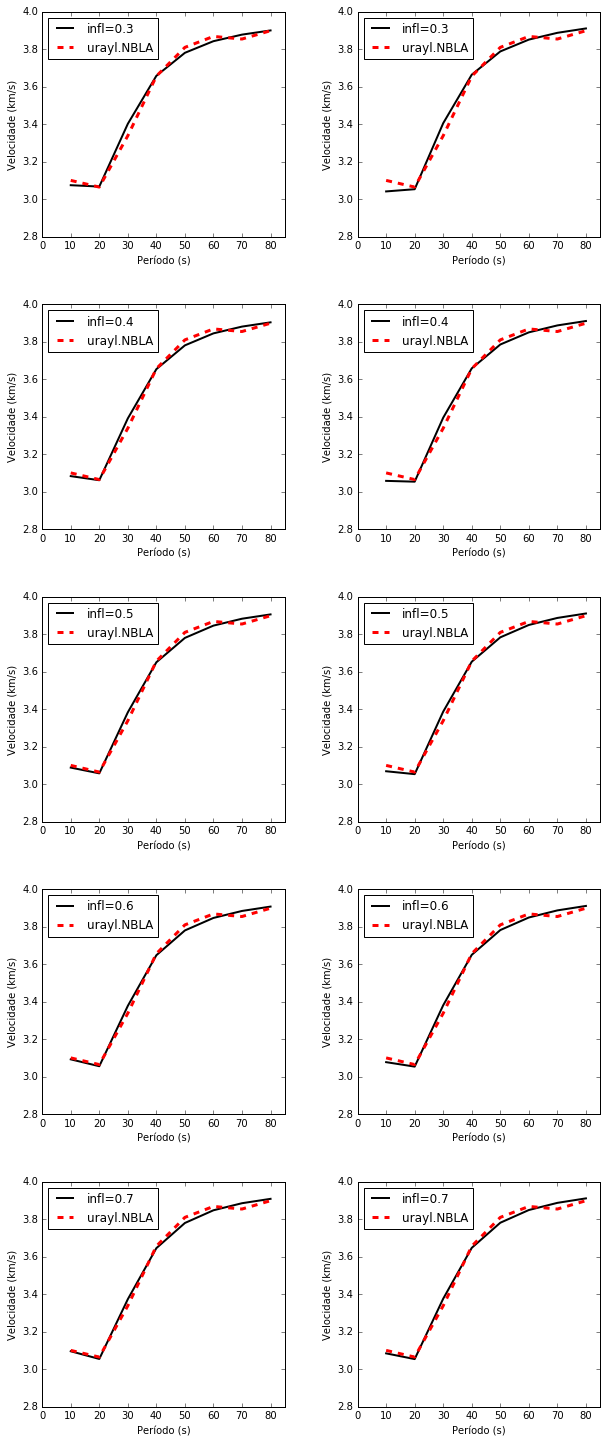

In [264]:
fig = mpl.figure(figsize = (10,25))
gs1 = gridspec.GridSpec(len(RF_joint_data1[0]),len(RF_joint_data1))
gs1.update(wspace=0.3, hspace=0.3)
for i,j in enumerate(CD_r_cur1):
    for h in range(len(CD_r_cur1[0])):
        ax1 = mpl.subplot(gs1[h,i])
        ax1.plot(periodsr1[i][h],CD_r_cur1[i][h],'k',lw=2,label='infl='+model_joint_label1[i][h])
        ax1.plot(periods,disp_curves,'--r',lw=3,label='urayl.NBLA')
        ax1.set_xlabel('Período (s)')
        ax1.set_ylabel('Velocidade (km/s)')   
        ax1.set_xlim(0,85)
        ax1.set_ylim(2.8,4)
        ax1.legend(loc=0)

<h2 align="center">Calculando a RMS entre as Funções do Receptor e Curvas de Dispersão geradas pela inversão jointsmth e pelos dados observados</h2>

In [275]:
def rootMeanSquare(Obs,Pred):

    err = Obs - Pred
    squareError = np.power(err,2)
    meanSquareError = np.mean(squareError) 
    rootMeanSquareError = np.sqrt(meanSquareError)
    
    return rootMeanSquareError

<h5>RMS entre as Funções do Receptor preditas e os dados observados</h5>

In [276]:
RF_true_grupo_1 = np.resize(RF_stack1[0],(500))
RF_true_grupo_2 = np.resize(RF_stack2[0],(500))

In [277]:
RF_RMS_grupo_1 = []
RF_RMS_grupo_2 = []
for k,l in enumerate(vs1[0]):
    RF_RMS_grupo_1.append(rootMeanSquare(RF_true_grupo_1,RF_joint_data1[0][k]))
    RF_RMS_grupo_2.append(rootMeanSquare(RF_true_grupo_2,RF_joint_data1[1][k]))

<h5>RMS entre as Curvas de Dispersão preditas e os dados observados</h5>

In [278]:
CD_RMS_grupo_1 = []
CD_RMS_grupo_2 = []
for k,l in enumerate(vs1[0]):
    CD_RMS_grupo_1.append(rootMeanSquare(disp_curves,CD_r_cur1[0][k]))
    CD_RMS_grupo_2.append(rootMeanSquare(disp_curves,CD_r_cur1[1][k]))

<h5>Gráfico	  do	  RMS	  para	  a	  dispersão	  em	  função	  do	  RMS	  para	  as	  funções	  de	  receptor</h5>

<h5>Gráfico	  do	  RMS	  para	  o grupo 1 - Função do Receptor com parâmetro do Raio entre 0.04 e 0.05</h5>

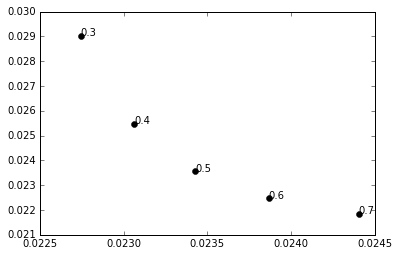

In [279]:
for i,j in enumerate(RF_RMS_grupo_1):
    mpl.plot(j,CD_RMS_grupo_1[i],'ok')
    mpl.text(j,CD_RMS_grupo_1[i],model_joint_label1[0][i])

<h5>Gráfico	  do	  RMS	  para	  o grupo 2 - Função do Receptor com parâmetro do Raio entre 0.06 e 0.07</h5>

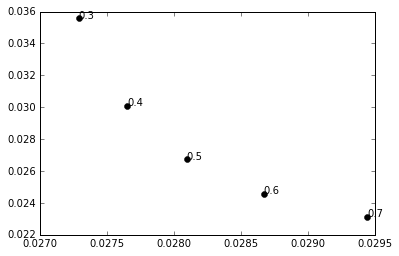

In [280]:
for i,j in enumerate(RF_RMS_grupo_2):
    mpl.plot(j,CD_RMS_grupo_2[i],'ok')
    mpl.text(j,CD_RMS_grupo_2[i],model_joint_label1[0][i])

<h3>Pelos gráficos do RMS podemos ver que para o grupo 1 o melhor parâmetro de influência é o de 0.5 e para o grupo 2 é o 0.5</h3>

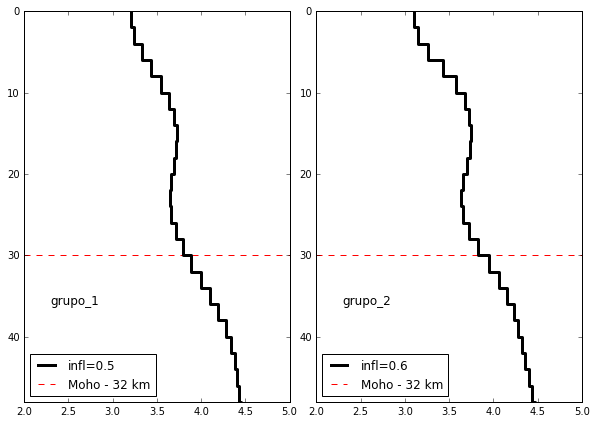

In [281]:
fig = mpl.figure(figsize = (10,7))
gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.1, hspace=0.1)

ax1 = mpl.subplot(gs1[0])
ax1.step(vs1[0][2],prof1[0][2],'k',lw=3,where='post',label='infl='+model_joint_label1[0][2])
ax1.hlines(30,2,5,'r',linestyles='dashed',label='Moho - 32 km')
ax1.text(2.3,36,stack_list[0],fontsize=12)
ax1.set_xlim([2,5])
ax1.set_ylim([48,0])
ax1.legend(loc=3)

ax2 = mpl.subplot(gs1[1])
ax2.step(vs1[1][2],prof1[1][2],'k',lw=3,where='post',label='infl='+model_joint_label1[1][3])
ax2.hlines(30,2,5,'r',linestyles='dashed',label='Moho - 32 km')
ax2.text(2.3,36,stack_list[1],fontsize=12)
ax2.set_xlim([2,5])
ax2.set_ylim([48,0])
ax2.legend(loc=3)

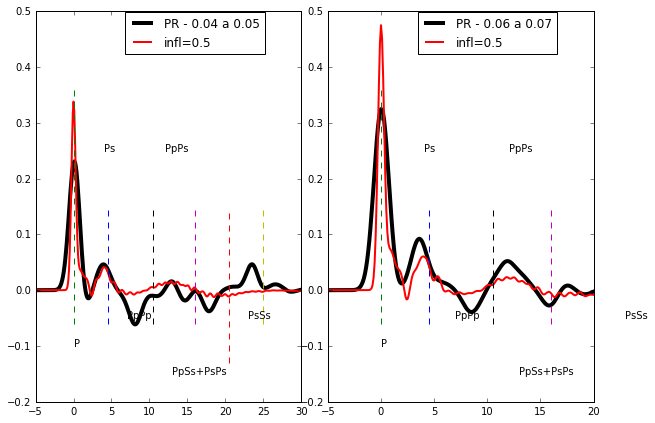

In [282]:
fig = mpl.figure(figsize = (10,7))
gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.1, hspace=0.1)

ax1 = mpl.subplot(gs1[0])
ax1.plot(RF_grupos[0].times()-5,RF_grupos[0].data,'k',lw=4,label=RF_grupos_label[0])
ax1.plot(RF_joint_time1[0][2]-5,RF_joint_data1[0][2],'r',lw=2,label='infl='+model_joint_label1[0][2])
ax1.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
ax1.text(0, -0.1, 'P')
ax1.axvline(x=4.5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
ax1.text(4, 0.25, 'Ps')
ax1.axvline(x=10.5, ymin=0.2, ymax=0.5, ls='dashed',c='k')
ax1.text(7, -0.05, 'PpPp')    
ax1.axvline(x=16, ymin=0.2, ymax=0.5, ls='dashed',c='m')
ax1.text(12, 0.25, 'PpPs')
ax1.axvline(x=20.5, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
ax1.text(13, -0.15, 'PpSs+PsPs')
ax1.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
ax1.text(23, -0.05, 'PsSs')
ax1.set_xlim(-5,30)
ax1.set_ylim(-0.2,0.5)
ax1.legend(bbox_to_anchor=(0.6, 1.0), loc=9, borderaxespad=0.1)

ax2 = mpl.subplot(gs1[1])
ax2.plot(RF_grupos[1].times()-5,RF_grupos[1].data,'k',lw=4,label=RF_grupos_label[1])
ax2.plot(RF_joint_time1[1][2]-5,RF_joint_data1[1][2],'r',lw=2,label='infl='+model_joint_label1[1][2])
ax2.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
ax2.text(0, -0.1, 'P')
ax2.axvline(x=4.5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
ax2.text(4, 0.25, 'Ps')
ax2.axvline(x=10.5, ymin=0.2, ymax=0.5, ls='dashed',c='k')
ax2.text(7, -0.05, 'PpPp')    
ax2.axvline(x=16, ymin=0.2, ymax=0.5, ls='dashed',c='m')
ax2.text(12, 0.25, 'PpPs')
ax2.axvline(x=20.5, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
ax2.text(13, -0.15, 'PpSs+PsPs')
ax2.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
ax2.text(23, -0.05, 'PsSs')
ax2.set_xlim(-5,20)
ax2.set_ylim(-0.2,0.5)
ax2.legend(bbox_to_anchor=(0.6, 1.0), loc=9, borderaxespad=0.1)

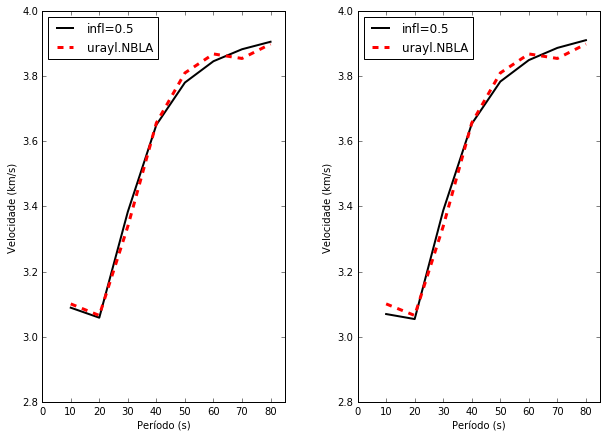

In [283]:
fig = mpl.figure(figsize = (10,7))
gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.3, hspace=0.3)

ax1 = mpl.subplot(gs1[0])
ax1.plot(periodsr1[0][2],CD_r_cur1[0][2],'k',lw=2,label='infl='+model_joint_label1[0][2])
ax1.plot(periods,disp_curves,'--r',lw=3,label='urayl.NBLA')
ax1.set_xlabel('Período (s)')
ax1.set_ylabel('Velocidade (km/s)')   
ax1.set_xlim(0,85)
ax1.set_ylim(2.8,4)
ax1.legend(loc=0)

ax2 = mpl.subplot(gs1[1])
ax2.plot(periodsr1[1][2],CD_r_cur1[1][2],'k',lw=2,label='infl='+model_joint_label1[1][2])
ax2.plot(periods,disp_curves,'--r',lw=3,label='urayl.NBLA')
ax2.set_xlabel('Período (s)')
ax2.set_ylabel('Velocidade (km/s)')   
ax2.set_xlim(0,85)
ax2.set_ylim(2.8,4)
ax2.legend(loc=0)